In [1]:
# General Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
import main
import seaborn as sns
import chromedriver_autoinstaller
from datetime import datetime
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
from collections import defaultdict
import pickle
import pickle
from PIL import Image
import urllib
import mplcyberpunk

In [2]:
chromedriver_autoinstaller.install()

import warnings
warnings.filterwarnings('ignore')

## Pull Data

In [3]:
chromedriver_autoinstaller.install()

if __name__ == "__main__":
    driver = webdriver.Chrome()
    
# whoscored match centre url of the required match (Example: Barcelona vs Sevilla)
url = "https://www.whoscored.com/Matches/1640737/Live/England-Premier-League-2022-2023-Fulham-Chelsea"
match_data = main.getMatchData(driver, url, close_window=True)

# Match dataframe containing info about the match
matches_df = main.createMatchesDF(match_data)

# Events dataframe      
events_df = main.createEventsDF(match_data)

# match Id
matchId = match_data['matchId']

# Information about respective teams as dictionary
home_data = matches_df['home'][matchId]
away_data = matches_df['away'][matchId]
score = matches_df['score'][matchId]
score = ' ' + score.replace(':', '-') + ' '

home_name = home_data['name']
away_name = away_data['name']
date = match_data['startDate'].split('T')[0]
date_ = datetime.strptime(date, '%Y-%m-%d').date()
date_str = date_.strftime('%d/%m/%Y')

Region: England, League: Premier League, Season: 2022/2023, Match Id: 1640737


In [4]:
homeID = home_data['teamId']
awayID = away_data['teamId']

## Colours 

In [5]:
home_color = '#9C9C9C'
away_color = '#2D5DE7'

# yellow = '#b4b400'

## XG Model
- Run shot data through our xG model, so we can get the xA and xG for individual players (and how they rank relative to distribution)
- First run through function which reduces it to the necessary form (described in detail in our xG model notebook)

In [6]:
pitch_length_x = 100
pitch_length_y = 100

feature_cols = ['id',
                'teamId',
                'prevTeam',
                'x', 
                'y',
                'playerName', 
                'playerAssist',
                'minute', 
                'second',
                'type',
                'prevEvent',
                'isGoal',
                'shotRightFoot',
                'shotLeftFoot',
                'shotHead',
                'shotOpenPlay',
                'shotSetPiece',
                'shotCounter', 
#                 'shotDirectCorner',
                'penaltyScored',
                'penaltyMissed',
                'goalOwn',
#                 'shotLongPass',
#                 'shotShortPass',
#                 'shotCross',
#                 'shotThroughBall',
                'bigChanceScored',
                'bigChanceMissed'
              ]

shot_types = ['SavedShot', 
              'MissedShots', 
              'Goal', 
              'ShotOnPost'
             ]


def shotData(df):
    df["passRecipient"] = df['playerName'].shift(-1)
    df['teamRecipient'] = df['teamId'].shift(-1)
    df['prevEvent'] = df['type'].shift(1)
    df['shotLongPass'] = df['keyPassLong'].shift(1)
    df['shotShortPass'] = df['keyPassShort'].shift(1)
    df['shotCross'] = df['keyPassCross'].shift(1)
    df['shotThroughBall'] = df['keyPassThroughball'].shift(1)
    df['playerAssist'] = df['playerName'].shift(1)
    df['prevTeam'] = df['teamId'].shift(1)

    column_to_move = df.pop("passRecipient")
    df.insert(29, "passRecipient", column_to_move)
    column_to_move = df.pop("teamRecipient")
    df.insert(27, "teamRecipient", column_to_move)
    column_to_move = df.pop('prevEvent')
    df.insert(11, "prevEvent", column_to_move)

    df_shots = df[df['type'].isin(shot_types)].reset_index(drop=True)[feature_cols]

    df_shots = df_shots[(df_shots['penaltyScored'] == False) & 
                        (df_shots['penaltyMissed'] == False) &
                        (df_shots['goalOwn'] == False)
                       ]
#     df_shots['shotTakeOn'] = df_shots['prevEvent'] == 'TakeOn'
#     df_shots['shotDefensiveAction'] = df_shots['prevEvent'].isin(['Challenge', 'Tackle', 'Interception', 'Clearance',
#                                                                   'BallRecovery', 'BlockedPass'])

    df_shots['distance_to_goal'] = np.sqrt(((pitch_length_x - df_shots['x'])**2 + 
                                    (pitch_length_y - df_shots['y'])**2))
    df_shots['distance_to_center'] = abs(df_shots['y'] - pitch_length_y/2)
    df_shots['angle'] = np.absolute(np.degrees(np.arctan((abs((pitch_length_y/2) - df_shots['y'])) 
                                                         / (pitch_length_x - df_shots['x']))))


    df_shots = df_shots.drop(['prevEvent', 'penaltyScored', 'penaltyMissed', 'goalOwn', 'type'], axis=1)
    
    # Add Big Chance Column
    df_shots['bigChance'] = df_shots['bigChanceMissed'] | df_shots['bigChanceScored']
    df_shots = df_shots.drop(['bigChanceMissed', 'bigChanceScored'], axis=1)

    cat_cols = ['shotRightFoot',
            'shotLeftFoot',
            'shotHead',
            'shotOpenPlay',
            'shotSetPiece',
#             'shotDirectCorner',
            'shotCounter',
#             'shotLongPass',
#             'shotShortPass',
#             'shotCross',
#             'shotThroughBall',
#             'shotTakeOn', 
#             'shotDefensiveAction',
            'bigChance'
           ]
    df_shots[cat_cols] *= 1
    
    obj_cols = [
#             'shotLongPass',
#             'shotShortPass',
#             'shotCross',
#             'shotThroughBall',
             ]
    
    for col in obj_cols:
        df_shots[col] = pd.to_numeric(df_shots[col])
    

    return df_shots 

In [7]:
data = shotData(events_df).reset_index(drop=True)
X_game = data.iloc[:, 10:]
Y_game = data['isGoal']

In [8]:
data

,id,teamId,prevTeam,x,y,playerName,playerAssist,minute,second,isGoal,shotRightFoot,shotLeftFoot,shotHead,shotOpenPlay,shotSetPiece,shotCounter,distance_to_goal,distance_to_center,angle,bigChance
0,2.496789e+09,15,15.0,90.0,47.3,Kai Havertz,João Félix,1,51.0,False,1,0,0,1,0,0,53.640377,2.7,15.109575,1
1,2.496789e+09,15,15.0,90.8,61.7,Lewis Hall,Kai Havertz,1,52.0,False,0,1,0,1,0,0,39.389466,11.7,51.821152,1
2,2.496791e+09,170,170.0,87.4,62.0,Carlos Vinícius,Antonee Robinson,7,26.0,False,0,1,0,1,0,0,40.034485,12.0,43.602819,0
3,2.496791e+09,15,170.0,78.5,47.8,Mateo Kovacic,Carlos Vinícius,9,10.0,False,1,0,0,0,1,0,56.454318,2.2,5.842489,0
4,2.496791e+09,15,170.0,85.8,51.3,Trevoh Chalobah,Tosin Adarabioyo,9,12.0,False,1,0,0,0,1,0,50.728000,1.3,5.230807,0
5,2.496791e+09,15,15.0,86.8,68.4,João Félix,Mateo Kovacic,9,15.0,False,1,0,0,0,1,0,34.246168,18.4,54.344672,0
6,2.496793e+09,15,15.0,74.6,45.8,João Félix,João Félix,16,4.0,False,1,0,0,1,0,0,59.856495,4.2,9.389148,0
7,2.496794e+09,15,15.0,81.2,50.7,Mateo Kovacic,Mason Mount,16,8.0,False,1,0,0,1,0,0,52.762960,0.7,2.132368,0
8,2.496794e+09,15,170.0,92.5,53.1,Thiago Silva,João Palhinha,16,46.0,False,0,0,1,0,1,0,47.495895,3.1,22.456939,0
9,2.496795e+09,170,170.0,77.1,45.7,Harrison Reed,Willian,20,24.0,False,1,0,0,0,1,0,58.931316,4.3,10.634761,0


In [9]:
# Import our xG model 
xg_model = pickle.load(open('xgModel_XGBoost22.sav', 'rb'))

In [10]:
y_pred_game = xg_model.predict_proba(X_game)
df_pred_game = pd.DataFrame(y_pred_game, columns = ['prob_no_goal', 'prob_goal'])
df_pred_game = pd.merge(data, df_pred_game, left_index=True, right_index=True)
df_pred_game

,id,teamId,prevTeam,x,y,playerName,playerAssist,minute,second,isGoal,...,shotHead,shotOpenPlay,shotSetPiece,shotCounter,distance_to_goal,distance_to_center,angle,bigChance,prob_no_goal,prob_goal
0,2.496789e+09,15,15.0,90.0,47.3,Kai Havertz,João Félix,1,51.0,False,...,0,1,0,0,53.640377,2.7,15.109575,1,0.619350,0.380650
1,2.496789e+09,15,15.0,90.8,61.7,Lewis Hall,Kai Havertz,1,52.0,False,...,0,1,0,0,39.389466,11.7,51.821152,1,0.602771,0.397229
2,2.496791e+09,170,170.0,87.4,62.0,Carlos Vinícius,Antonee Robinson,7,26.0,False,...,0,1,0,0,40.034485,12.0,43.602819,0,0.920551,0.079449
3,2.496791e+09,15,170.0,78.5,47.8,Mateo Kovacic,Carlos Vinícius,9,10.0,False,...,0,0,1,0,56.454318,2.2,5.842489,0,0.979217,0.020783
4,2.496791e+09,15,170.0,85.8,51.3,Trevoh Chalobah,Tosin Adarabioyo,9,12.0,False,...,0,0,1,0,50.728000,1.3,5.230807,0,0.917116,0.082884
5,2.496791e+09,15,15.0,86.8,68.4,João Félix,Mateo Kovacic,9,15.0,False,...,0,0,1,0,34.246168,18.4,54.344672,0,0.975611,0.024389
6,2.496793e+09,15,15.0,74.6,45.8,João Félix,João Félix,16,4.0,False,...,0,1,0,0,59.856495,4.2,9.389148,0,0.955738,0.044262
7,2.496794e+09,15,15.0,81.2,50.7,Mateo Kovacic,Mason Mount,16,8.0,False,...,0,1,0,0,52.762960,0.7,2.132368,0,0.892242,0.107758
8,2.496794e+09,15,170.0,92.5,53.1,Thiago Silva,João Palhinha,16,46.0,False,...,1,0,1,0,47.495895,3.1,22.456939,0,0.941317,0.058683
9,2.496795e+09,170,170.0,77.1,45.7,Harrison Reed,Willian,20,24.0,False,...,0,0,1,0,58.931316,4.3,10.634761,0,0.967975,0.032025


In [11]:
xg_moving = df_pred_game[['teamId', 'minute', 'prob_goal', 'isGoal']]

# Add Penalites manually
pens_scored = events_df[(events_df['penaltyScored'] == True)][['teamId', 'minute']].reset_index(drop=True)
pens_missed = events_df[(events_df['penaltyMissed'] == True)][['teamId', 'minute']].reset_index(drop=True)

for i in range(len(pens_scored)):
    team = pens_scored['teamId'][i]
    minute = pens_scored['minute'][i]
    xg_moving.loc[len(xg_moving)+1] = [team, minute, 0.75, True]
    

for i in range(len(pens_missed)):
    team = pens_missed['teamId'][i]
    minute = pens_missed['minute'][i]
    xg_moving.loc[len(xg_moving)+1] = [team, minute, 0.75, False]
    
xg_moving = xg_moving.sort_values(by='minute').reset_index(drop=True)


xg_moving['cumSum'] = ''
prev_h = 0
prev_a = 0

for i, row in xg_moving.iterrows():
    if xg_moving['teamId'][i] == homeID:
        xg_moving['cumSum'][i] = prev_h + xg_moving['prob_goal'][i]
        prev_h = xg_moving['cumSum'][i]
    else:
        xg_moving['cumSum'][i] = prev_a + xg_moving['prob_goal'][i]
        prev_a = xg_moving['cumSum'][i]


In [12]:
xg_moving_h = xg_moving[xg_moving['teamId'] == homeID].reset_index(drop=True)
xg_moving_a = xg_moving[xg_moving['teamId'] == awayID].reset_index(drop=True)


In [13]:
xg_moving_h

,teamId,minute,prob_goal,isGoal,cumSum
0,170,7,0.079449,False,0.079449
1,170,20,0.032025,False,0.111473
2,170,22,0.102132,False,0.213606
3,170,22,0.032550,False,0.246156
4,170,24,0.051885,True,0.298041
5,170,43,0.024177,False,0.322218
6,170,52,0.012746,False,0.334964
7,170,72,0.296158,True,0.631123


In [14]:
minute = xg_moving_h.loc[0]['minute']
xg_moving_h.loc[-1] = [homeID, minute-1, 0, False, 0]
xg_moving_h.loc[-2] = [homeID, 0, 0, False, 0]
xg_moving_h.index = xg_moving_h.index + 2
xg_moving_h = xg_moving_h.sort_index() 
xg_moving_h

minute = xg_moving_a.loc[0]['minute']
xg_moving_a.loc[-1] = [awayID, minute-1, 0, False, 0]
xg_moving_a.loc[-2] = [awayID, 0, 0, False, 0]
xg_moving_a.index = xg_moving_a.index + 2  
xg_moving_a = xg_moving_a.sort_index() 
xg_moving_a

,teamId,minute,prob_goal,isGoal,cumSum
0,15,0,0.000000,False,0
1,15,0,0.000000,False,0
2,15,1,0.380650,False,0.38065
3,15,1,0.397229,False,0.777879
4,15,9,0.020783,False,0.798662
5,15,9,0.082884,False,0.881546
6,15,9,0.024389,False,0.905935
7,15,16,0.044262,False,0.950198
8,15,16,0.107758,False,1.057955
9,15,16,0.058683,False,1.116638


In [15]:
full_time = events_df['minute'].max()
home_xg_final = xg_moving_h.loc[len(xg_moving_h)-1]['cumSum']
xg_moving_h.loc[len(xg_moving_h)] = [homeID, full_time, 0, False, home_xg_final]
xg_moving_h

away_xg_final = xg_moving_a.loc[len(xg_moving_a)-1]['cumSum']
xg_moving_a.loc[len(xg_moving_a)] = [awayID, full_time, 0, False, away_xg_final]
xg_moving_a

,teamId,minute,prob_goal,isGoal,cumSum
0,15,0,0.000000,False,0
1,15,0,0.000000,False,0
2,15,1,0.380650,False,0.38065
3,15,1,0.397229,False,0.777879
4,15,9,0.020783,False,0.798662
5,15,9,0.082884,False,0.881546
6,15,9,0.024389,False,0.905935
7,15,16,0.044262,False,0.950198
8,15,16,0.107758,False,1.057955
9,15,16,0.058683,False,1.116638


In [16]:
home_goals = xg_moving_h[xg_moving_h['isGoal'] == True].reset_index(drop=True)
away_goals = xg_moving_a[xg_moving_a['isGoal'] == True].reset_index(drop=True)
home_goals

,teamId,minute,prob_goal,isGoal,cumSum
0,170,24,0.051885,True,0.298041
1,170,72,0.296158,True,0.631123


## Metrics 

In [17]:
metrics = []

## xG

In [18]:
home_xg = round(xg_moving_h['cumSum'][len(xg_moving_h)-1],2)
away_xg = round(xg_moving_a['cumSum'][len(xg_moving_a)-1],2)
metrics.append(['xg', home_xg, away_xg])

## Expected Points and Win Prob
- Assuming Poisson distribution here 
- Just running 1,000,000 scenarios and looking at the outcomes

In [19]:
sims = 1000000

home_wins = 0
away_wins = 0
draws = 0

for _ in range(sims):
    home_goals_sim = np.random.poisson(home_xg)
    away_goals_sim = np.random.poisson(away_xg)
    
    if home_goals_sim > away_goals_sim:
        home_wins += 1
        
    if away_goals_sim > home_goals_sim:
        away_wins += 1
        
    if home_goals_sim == away_goals_sim:
        draws += 1
        
        
home_win_prob = home_wins/sims
away_win_prob = away_wins/sims
draw_prob = draws/sims

In [20]:
home_xp = (home_win_prob*3) + (draw_prob*1)
away_xp = (away_win_prob*3) + (draw_prob*1)

In [21]:
metrics.append(['xPts', round(home_xp,2), round(away_xp,2)])
metrics.append(['Win Probability', str(int(home_win_prob*100))+'%', str(int(away_win_prob*100))+'%'])

## Big Chances  

In [22]:
home_bc = len(xg_moving_h[xg_moving_h['prob_goal'] > 0.275])
away_bc = len(xg_moving_a[xg_moving_a['prob_goal'] > 0.275])
metrics.append(['Big Chances', home_bc, away_bc])

In [23]:
df_pred_game

,id,teamId,prevTeam,x,y,playerName,playerAssist,minute,second,isGoal,...,shotHead,shotOpenPlay,shotSetPiece,shotCounter,distance_to_goal,distance_to_center,angle,bigChance,prob_no_goal,prob_goal
0,2.496789e+09,15,15.0,90.0,47.3,Kai Havertz,João Félix,1,51.0,False,...,0,1,0,0,53.640377,2.7,15.109575,1,0.619350,0.380650
1,2.496789e+09,15,15.0,90.8,61.7,Lewis Hall,Kai Havertz,1,52.0,False,...,0,1,0,0,39.389466,11.7,51.821152,1,0.602771,0.397229
2,2.496791e+09,170,170.0,87.4,62.0,Carlos Vinícius,Antonee Robinson,7,26.0,False,...,0,1,0,0,40.034485,12.0,43.602819,0,0.920551,0.079449
3,2.496791e+09,15,170.0,78.5,47.8,Mateo Kovacic,Carlos Vinícius,9,10.0,False,...,0,0,1,0,56.454318,2.2,5.842489,0,0.979217,0.020783
4,2.496791e+09,15,170.0,85.8,51.3,Trevoh Chalobah,Tosin Adarabioyo,9,12.0,False,...,0,0,1,0,50.728000,1.3,5.230807,0,0.917116,0.082884
5,2.496791e+09,15,15.0,86.8,68.4,João Félix,Mateo Kovacic,9,15.0,False,...,0,0,1,0,34.246168,18.4,54.344672,0,0.975611,0.024389
6,2.496793e+09,15,15.0,74.6,45.8,João Félix,João Félix,16,4.0,False,...,0,1,0,0,59.856495,4.2,9.389148,0,0.955738,0.044262
7,2.496794e+09,15,15.0,81.2,50.7,Mateo Kovacic,Mason Mount,16,8.0,False,...,0,1,0,0,52.762960,0.7,2.132368,0,0.892242,0.107758
8,2.496794e+09,15,170.0,92.5,53.1,Thiago Silva,João Palhinha,16,46.0,False,...,1,0,1,0,47.495895,3.1,22.456939,0,0.941317,0.058683
9,2.496795e+09,170,170.0,77.1,45.7,Harrison Reed,Willian,20,24.0,False,...,0,0,1,0,58.931316,4.3,10.634761,0,0.967975,0.032025


## Box Shots 

In [24]:
pens_h_count = len(pens_scored[pens_scored['teamId'] == homeID]) + len(pens_missed[pens_missed['teamId'] == homeID])
pens_a_count = len(pens_scored[pens_scored['teamId'] == awayID]) + len(pens_missed[pens_missed['teamId'] == awayID])

In [25]:
home_boxshots = len(df_pred_game[(df_pred_game['teamId'] == homeID) & 
                   (df_pred_game['x'] >= 83) & 
                   (df_pred_game['y'] >= 21.1) & 
                   (df_pred_game['y'] <= 78.9)].reset_index(drop=True)) + pens_h_count


away_boxshots = len(df_pred_game[(df_pred_game['teamId'] == awayID) & 
                   (df_pred_game['x'] >= 83) & 
                   (df_pred_game['y'] >= 21.1) & 
                   (df_pred_game['y'] <= 78.9)].reset_index(drop=True)) + pens_a_count
metrics.append(['Box Shots', home_boxshots, away_boxshots])
metrics

[['xg', 0.63, 2.75],
 ['xPts', 0.3, 2.57],
 ['Win Probability', '5%', '81%'],
 ['Big Chances', 1, 4],
 ['Box Shots', 6, 14]]

In [26]:
df_pred_game[df_pred_game['teamId'] == awayID]

,id,teamId,prevTeam,x,y,playerName,playerAssist,minute,second,isGoal,...,shotHead,shotOpenPlay,shotSetPiece,shotCounter,distance_to_goal,distance_to_center,angle,bigChance,prob_no_goal,prob_goal
0,2.496789e+09,15,15.0,90.0,47.3,Kai Havertz,João Félix,1,51.0,False,...,0,1,0,0,53.640377,2.7,15.109575,1,0.619350,0.380650
1,2.496789e+09,15,15.0,90.8,61.7,Lewis Hall,Kai Havertz,1,52.0,False,...,0,1,0,0,39.389466,11.7,51.821152,1,0.602771,0.397229
3,2.496791e+09,15,170.0,78.5,47.8,Mateo Kovacic,Carlos Vinícius,9,10.0,False,...,0,0,1,0,56.454318,2.2,5.842489,0,0.979217,0.020783
4,2.496791e+09,15,170.0,85.8,51.3,Trevoh Chalobah,Tosin Adarabioyo,9,12.0,False,...,0,0,1,0,50.728000,1.3,5.230807,0,0.917116,0.082884
5,2.496791e+09,15,15.0,86.8,68.4,João Félix,Mateo Kovacic,9,15.0,False,...,0,0,1,0,34.246168,18.4,54.344672,0,0.975611,0.024389
6,2.496793e+09,15,15.0,74.6,45.8,João Félix,João Félix,16,4.0,False,...,0,1,0,0,59.856495,4.2,9.389148,0,0.955738,0.044262
7,2.496794e+09,15,15.0,81.2,50.7,Mateo Kovacic,Mason Mount,16,8.0,False,...,0,1,0,0,52.762960,0.7,2.132368,0,0.892242,0.107758
8,2.496794e+09,15,170.0,92.5,53.1,Thiago Silva,João Palhinha,16,46.0,False,...,1,0,1,0,47.495895,3.1,22.456939,0,0.941317,0.058683
13,2.496797e+09,15,15.0,85.5,63.8,João Félix,Mateo Kovacic,27,48.0,False,...,0,1,0,0,38.996025,13.8,43.583079,0,0.929471,0.070529
14,2.496800e+09,15,15.0,95.6,53.8,João Félix,Mateo Kovacic,32,27.0,False,...,0,1,0,0,46.409051,3.8,40.815084,1,0.405140,0.594860


## Plot 

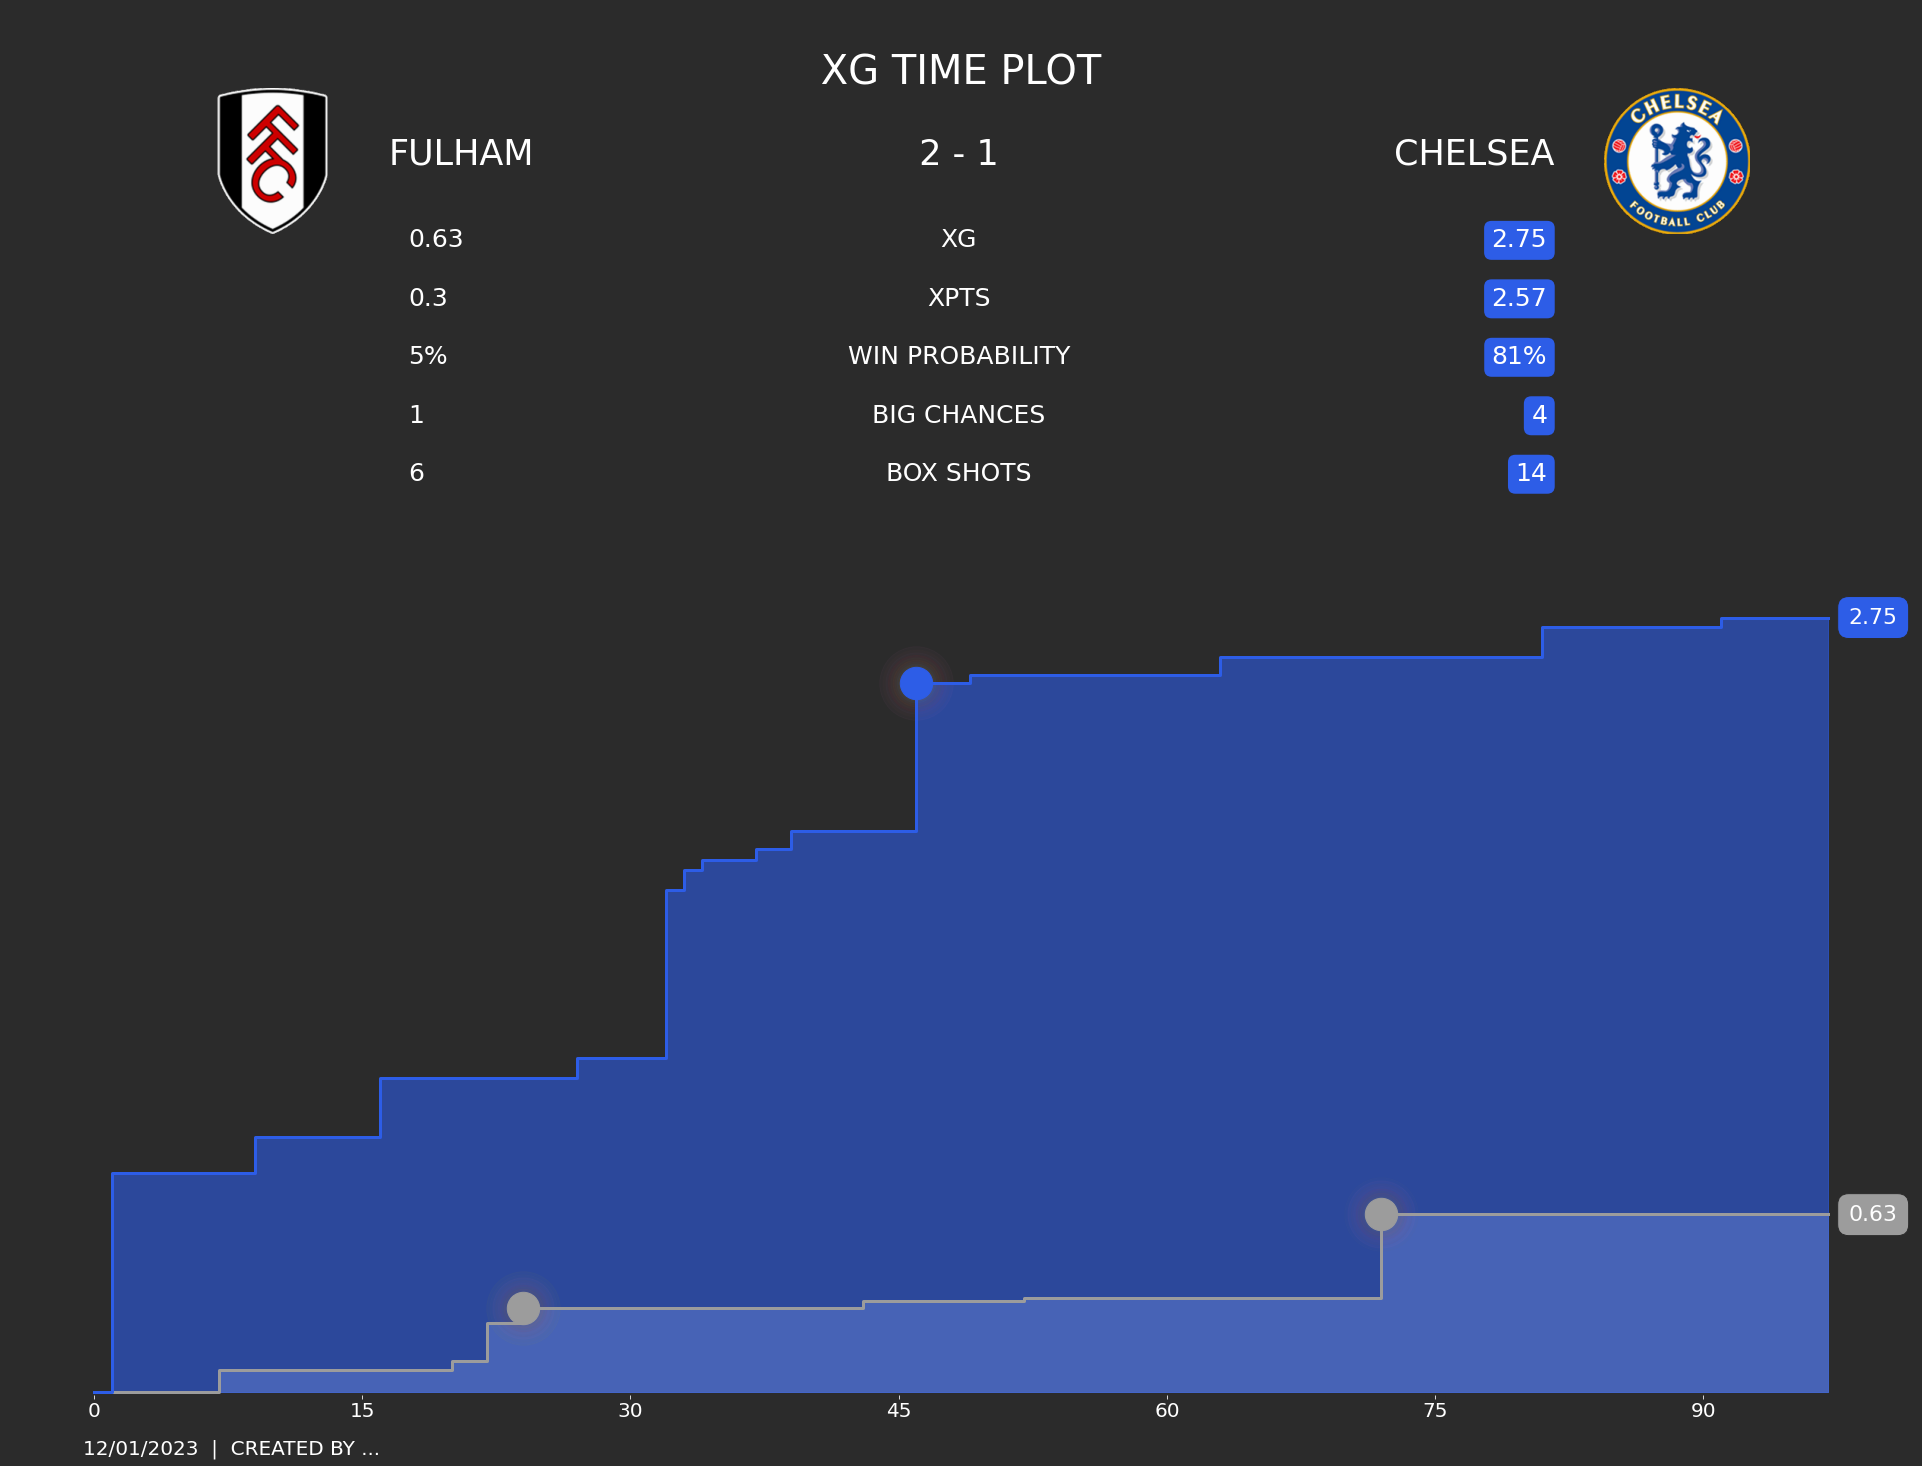

In [27]:
#### import mplcyberpunk
# plt.style.use("cyberpunk")

fig, ax = plt.subplots(figsize = (20,15))
fig.set_facecolor("#2B2B2B")
ax.patch.set_facecolor("#2B2B2B")

plt.xticks([0, 15, 30, 45, 60, 75, 90])
ax.axes.get_yaxis().set_visible(False)
ax.tick_params(axis='x', colors='white')

ax.step(x=xg_moving_h.minute, y=xg_moving_h.cumSum, color=home_color, where='post', lw=3)
ax.step(x=xg_moving_a.minute, y=xg_moving_a.cumSum, color=away_color, where='post', lw=3)
ax.set_ylim(ymin=-0.01)
# ax.grid(ls='--', color='darkgrey')
# ax.fill_between(xg_moving_h.minute, xg_moving_h.cumSum, xg_moving_a.cumSum, color='b', alpha=0.3, 
#                 where=xg_moving_h.cumSum < xg_moving_a.cumSum)

ax.fill_between(x=xg_moving_h.minute,y1=0, y2=xg_moving_h['cumSum'].tolist(), color=home_color, step='post', 
                 alpha=0.6)
ax.fill_between(x=xg_moving_a.minute,y1=0, y2=xg_moving_a['cumSum'].tolist(), color=away_color, step='post', 
                 alpha=0.6)


end_minute = xg_moving_h['minute'][len(xg_moving_h)-1]
end_h_xg =  round(xg_moving_h['cumSum'][len(xg_moving_h)-1],2)

ax.annotate(text=str(end_h_xg), xytext=(end_minute+2.5, end_h_xg), xy=(0, 0), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='#2B2B2B', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=22)


end_minute = xg_moving_a['minute'][len(xg_moving_a)-1]
end_a_xg =  round(xg_moving_a['cumSum'][len(xg_moving_a)-1],2)

ax.annotate(text=str(end_a_xg), xytext=(end_minute+2.5, end_a_xg), xy=(0, 0), ha='center', va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='#2B2B2B', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=22)


plt.title(" \n xG Time Plot ".upper() , fontname='Sans Serif', color='white', fontsize=40, loc='center', y=1.6, x=0.5)

# ax.annotate(text=home_name.upper() , xytext=(20, 2.15), xy=(0,0), ha='left', color='white', 
#             fontname='Sans Serif', fontsize=35)
# ax.annotate(text=score , xytext=(50, 2.15), xy=(0,0), ha='center', color='white', 
#             fontname='Sans Serif', fontsize=35)
# ax.annotate(text=away_name.upper() , xytext=(80, 2.15), xy=(0,0), ha='right', color='white', 
#             fontname='Sans Serif', fontsize=35)

plt.figtext(0.1775, 0.07, date_str.upper() + '  |  ' + "CREATED BY ...", ha="left", fontsize=20, fontname='Sans Serif', color='white')


for i in range(len(home_goals)):
    minute = home_goals['minute'][i]
    y = home_goals['cumSum'][i]
    ax.scatter(minute, y, marker='o', color=home_color, s=1050, zorder=3)
    mplcyberpunk.make_scatter_glow()
    

for i in range(len(away_goals)):
    minute = away_goals['minute'][i]
    y = away_goals['cumSum'][i]
    ax.scatter(minute, y, marker='o', color=away_color, s=1050, zorder=3)
    mplcyberpunk.make_scatter_glow()


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(False)

fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
team_logos = 8455
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos:.0f}.png'))
newax = fig.add_axes([1.2, 1.2, 0.135, 0.135], anchor='NE', zorder=2)
newax.imshow(club_icon)
newax.axis('off')
newax.annotate(text=away_name.upper() , xytext=(-65, 100), xy=(0,0), ha='right', color='white', 
               fontname='Sans Serif', fontsize=35)
newax.annotate(text=score , xytext=(-850, 100), xy=(0,0), ha='center', color='white', 
               fontname='Sans Serif', fontsize=35)

y=200
for metric, home, away in metrics:
    if isinstance(home,int) or isinstance(home,np.float32) or isinstance(home,float):
        home2 = home
        
    if isinstance(away,int) or isinstance(away,np.float32) or isinstance(away,float):
        away2 = away
    
    if isinstance(home,str):
        home2 = home[:]
        home = home.replace('%', '')

    if isinstance(away, str):
        away2 = away[:]
        away = away.replace('%', '')
    
    color_box = ''
    if float(home)>float(away):
        color_box = home_color
    elif float(home)<float(away):
        color_box = away_color
    else:
        color_box = ''
        
    newax.annotate(text=metric.upper(), 
                          xytext=(-850, y), xy=(0, 0), ha='center', va='center', color='white',
                     fontname = 'Sans Serif', fontsize=25)
    
        
    if color_box == home_color: 
        newax.annotate(text=str(home2), xytext=(-1575,y), xy=(0, 0), ha='left', va='center', color='white',
                         bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.3'),
                         fontname = 'Sans Serif', fontsize=25)
        newax.annotate(text=str(away2), xytext=(-75,y),xy=(0, 0), ha='right', va='center', color='white',
                         fontname = 'Sans Serif', fontsize=25)

        
    if color_box == away_color:
        newax.annotate(text=str(home2), xytext=(-1575,y), xy=(0, 0), ha='left', va='center', color='white',
                     fontname = 'Sans Serif', fontsize=25)
        newax.annotate(text=str(away2), xytext=(-75,y), xy=(0, 0), ha='right', va='center', color='white',
                        bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.3'),
                         fontname = 'Sans Serif', fontsize=25)
        
        
    else:
        newax.annotate(text=str(home2), xytext=(-1575,y), xy=(0, 0), ha='left', va='center', color='white',
                         fontname = 'Sans Serif', fontsize=25)
        newax.annotate(text=str(away2), xytext=(-75,y), xy=(0, 0), ha='right', va='center', color='white',
                         fontname = 'Sans Serif', fontsize=25)
    y += 77







team_logos2 = 9879
club_icon2 = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos2:.0f}.png'))
newax2 = fig.add_axes([0.225, 1.2, 0.135, 0.135], anchor='NE', zorder=2)
newax2.imshow(club_icon2)
newax2.axis('off')
newax.annotate(text=home_name.upper() , xytext=(-1600.25, 100), xy=(0,0), ha='left', color='white', 
               fontname='Sans Serif', fontsize=35)

fig.subplots_adjust(right=1.45) # or whatever
ax.tick_params(axis='both', which='major', labelsize=20)


fig.savefig('xgplot.png', 
            bbox_inches="tight",
            edgecolor="none",
            facecolor = "#2B2B2B",
            dpi=300)